# Figure 3: Benchmarks

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from os import path
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.tasks.sir import SIR
from loss_cal.tasks.lotka_volterra import LotkaVolterra
from loss_cal.tasks.linear_gaussian import LinGauss
# from loss_cal.npe import load_npes
# from loss_cal.predictor import load_predictors
# from loss_cal.costs import RevGaussCost, expected_posterior_costs_given_posterior_samples
# from loss_cal.utils.analysis import find_optimal_action


plot_config_file = "loss_cal/utils/.matplotlibrc"
color_npe = "#377eb8"
color_nn = "#ff7f00"
color_post = "#4daf4a"
save_dir = "./paper/fig3/"

Benchmark Tasks: SIR, LV, LinGauss

In [3]:
bm_tasks = {
    "toy_example": ToyExample(action_type="continuous"),
    "sir": SIR(action_type="continuous"),
    "lotka_volterra": LotkaVolterra(action_type="continuous"),
    "linear_gaussian": LinGauss(action_type="continuous"),
}
# bm_tasks_factors = {
#     "toy": 3.,
#     "sir": 2.,
#     "lotka_volterra": [2.0, 5.0, 2.0, 5.0],
#     "linear_gaussian": 2.,
# }
# bm_tasks_exponentials = {
#     "toy": 1.,
#     "sir": 0.5,
#     "lotka_volterra": [1.0, 0.5, 1.0, 0.5],
#     "linear_gaussian": 1.,
# }

### Difference Incurred Costs

In [4]:
posterior_costs = torch.stack([torch.load(f"./results/sir/continuous/fig_diff_costs/seed{seed}_posterior_costs.pt") for seed in [0,54]]).mean(dim=0)

In [5]:
posterior_costs.shape

torch.Size([6, 10])

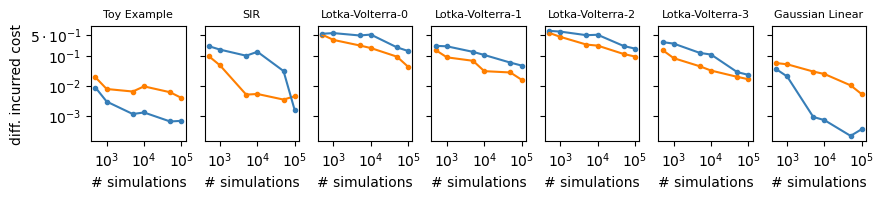

In [6]:
num_npe_samples = 1000
test_nsim = [500, 1_000, 5_000, 10_000, 50_000, 100_000]
test_seeds = [0, 54, 943]
seed = 0


fig, axes = plt.subplots(1, 7, figsize=(10, 1.5), sharey=True, sharex=True)
# axes[0].set_ylim(0.0,0.7)
axes[0].set_yscale("log")
axes[0].set_ylabel("diff. incurred cost")
axes[0].set_yticks([0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5])

axes[0].set_xscale("log")
axes[0].set_xticks([1000, 10000, 100000])  # , labels=[r"$10^3$", r"$10^4$", r"$10^5$"], rotation=90)
axes[0].set_xlabel("# simulations")
i = 0

with mpl.rc_context(fname=plot_config_file):
    for bm_task in list(bm_tasks.keys()):
        task = bm_tasks[bm_task]
        task_name = task.task_name

        # posterior_costs = torch.load(f"./results/{bm_task}/continuous/fig_diff_costs/seed{seed}_posterior_costs.pt")
        # nn_costs = torch.load(f"./results/{bm_task}/continuous/fig_diff_costs/seed{seed}_nn_costs.pt")
        # npe_costs = torch.load(f"./results/{bm_task}/continuous/fig_diff_costs/seed{seed}_npe_costs.pt")
        posterior_costs = torch.stack(
            [
                torch.load(f"./results/{bm_task}/continuous/fig_diff_costs/seed{seed}_posterior_costs.pt")
                for seed in [0, 54, 943]
            ]
        ).mean(dim=0)
        nn_costs = torch.stack(
            [
                torch.load(f"./results/{bm_task}/continuous/fig_diff_costs/seed{seed}_nn_costs.pt")
                for seed in [0, 54, 943]
            ]
        ).mean(dim=0)
        npe_costs = torch.stack(
            [
                torch.load(f"./results/{bm_task}/continuous/fig_diff_costs/seed{seed}_npe_costs.pt")
                for seed in [0, 54, 943]
            ]
        ).mean(dim=0)

        if task_name == "lotka_volterra":
            for p in range(task.dim_parameters):
                axes[i + p].set_title(task.display_name + f"-{p}")
                axes[i + p].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
                axes[i + p].get_xaxis().set_tick_params(which="minor", size=0)
                axes[i + p].set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
                axes[i + p].set_xlabel("# simulations")
                axes[i + p].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
                axes[i + p].get_yaxis().set_tick_params(which="minor", size=0)
                axes[i + p].set_yticklabels(
                    [r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$5\cdot10^{-1}$"]
                )
                # plot incurred costs
                axes[i + p].plot(
                    test_nsim, (posterior_costs - posterior_costs).mean(dim=2)[:, p], c=color_post, label="ground truth"
                )
                axes[i + p].plot(test_nsim, (nn_costs - posterior_costs).mean(dim=2)[:, p], c=color_nn, label="NN")
                axes[i + p].plot(test_nsim, (npe_costs - posterior_costs).mean(dim=2)[:, p], c=color_npe, label="NPE")
                # scatter data points on top
                axes[i + p].scatter(test_nsim, (posterior_costs - posterior_costs).mean(dim=2)[:, p], c=color_post)
                axes[i + p].scatter(test_nsim, (nn_costs - posterior_costs).mean(dim=2)[:, p], c=color_nn)
                axes[i + p].scatter(test_nsim, (npe_costs - posterior_costs).mean(dim=2)[:, p], c=color_npe)

            i = i + p + 1
        else:
            axes[i].set_title(task.display_name)
            axes[i].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            axes[i].get_xaxis().set_tick_params(which="minor", size=0)
            axes[i].set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
            axes[i].set_xlabel("# simulations")
            axes[i].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            axes[i].get_yaxis().set_tick_params(which="minor", size=0)
            axes[i].set_yticklabels(
                [r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$5\cdot10^{-1}$"]
            )

            # plot incurred costs
            axes[i].plot(test_nsim, (posterior_costs - posterior_costs).mean(dim=1), c=color_post, label="ground truth")
            axes[i].plot(test_nsim, (nn_costs - posterior_costs).mean(dim=1), c=color_nn, label="NN")
            axes[i].plot(test_nsim, (npe_costs - posterior_costs).mean(dim=1), c=color_npe, label="NPE")
            # scatter data points on top
            axes[i].scatter(test_nsim, (posterior_costs - posterior_costs).mean(dim=1), c=color_post)
            axes[i].scatter(test_nsim, (nn_costs - posterior_costs).mean(dim=1), c=color_nn)
            axes[i].scatter(test_nsim, (npe_costs - posterior_costs).mean(dim=1), c=color_npe)

            i = i + 1
# axes[3].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.7))
plt.savefig("./paper/fig3/panel_a.svg")
plt.show()

diff in incurred costs = deviation from ground truth (posterior would be at 0)

### Expected Costs

### Combine figures to one multipanel figure

In [7]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("21.59cm", "5.0cm", #20.3 = width of document (check!)
           
    Panel(
          SVG("./paper/fig3/panel_a.svg").scale(svg_scale),
          Text("a", 20., 2.0, **kwargs_text),
    ).move(-10, 20),
)

f

In [8]:
# !mkdir -p fig
f.save("./paper/fig3/fig3.svg")
# svg("./paper/fig2/fig2.png")